### About:
This notebook is the initial exploration into the beer_data gathered by Andrew Carr from scraping the web. The original git repo can be foud [here](https://github.com/datadiarist/Beer_Data).

The dataset is simple, with three attributes:
- beer_full: the brewery/beer name
- user_score: the users rating of a particular beer
- user_id

There are **5,487,730** total reviews by 102,606 users, and a total of 24,542 unique beers that were reviewed.

In this notebook, I load the four data files into a single dataframe and begin exploration by grouping by user and then grouping by beer. I'm looking to see whether or not this dataset could be used to build a predictor, so that a user who reviews beer within the dataset can be recommended other beers from the dataset. I found that the average number of reviews per user is ~54 and the median is 6, the majority of users have left less than 10 reviews. the average number of reviews per beer is ~223, while the median is 54, about 16% have less than 25 reviews.

If I were to drop all beers with less than 25 reviews, I could make a one hot encoded matrix where the rows/samples are about 100,000 users and the attributes are 20,688 beers.

Finally, I added a 'beer_id' column to the original dataframe and removed the beer_full (names) column. I also made dictionaries to convert beer names to their ID's, and visa versa.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2

In [2]:
# loads all beer data, which is split over four files. Combines the data and returns a single dataframe 
def get_data():
    path = "./Beer_Data/beer_data*.csv"
    dfs = []
    filepaths = glob.glob(path)                         # get list of all .csv files in filepath
    for filepath in filepaths:
        dfs.append(pd.read_csv(filepath, header=0))     # create list of df's, then append them and return
    
    return dfs[0].append(dfs[1:], ignore_index=True)


In [3]:
df_orig = get_data().sort_values(by=['user_id'], ignore_index=True)

In [4]:
df_orig

,beer_full,user_score,user_id
0,Saint Arnold Brewing Company Spring Bock,3.75,1
1,Saint Arnold Brewing Company Homefront IPA,4.25,1
2,Saint Arnold Brewing Company Summer Pils,4.25,1
3,Buffalo Bayou Brewing Co Secessionist #1 (Ging...,4.25,1
4,(512) Brewing Company (512) Black IPA,4.50,1
...,...,...,...
5487725,Sierra Nevada Brewing Co. Sierra Nevada Pale Ale,3.50,102604
5487726,Sierra Nevada Brewing Co. Ruthless Rye IPA,3.50,102604
5487727,Sierra Nevada Brewing Co. Southern Hemisphere ...,3.82,102605
5487728,Steinhaus Brewing Co. Mission St. India Pale Ale,4.17,102605


In [5]:
user_group = df_orig.groupby('user_id')

In [6]:
# build a dataframe that shows the number of reviews each user has
user_num_reviews_df = user_group.count().drop(columns=['user_score']).rename(columns={'beer_full': 'num_reviews'})

In [7]:
user_num_reviews_df = user_num_reviews_df.reset_index()
user_num_reviews_df.head(10)

,user_id,num_reviews
0,1,27
1,2,370
2,3,5391
3,4,412
4,5,2440
5,6,226
6,7,245
7,8,64
8,9,4283
9,10,4


In [14]:
# a few statistics about number of user reviews per user
print('average number of reviews by a user:\t', user_num_reviews_df['num_reviews'].mean())
print('median of reiviews by a user:\t\t', user_num_reviews_df['num_reviews'].median())
print('max number of reviews by a user:\t', user_num_reviews_df['num_reviews'].max())

average number of reviews by a user:	 53.483519482291484
median of reiviews by a user:		 6.0
max number of reviews by a user:	 5564


In [15]:
print('% users with less than 25 reviews:', 
       user_num_reviews_df[user_num_reviews_df['num_reviews'] < 10]['num_reviews'].count()/user_num_reviews_df['num_reviews'].count())

% users with less than 25 reviews: 0.590101943356139


(array([451., 145.,  77.,  36.,  12.,   7.,   8.,   3.,   5.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([1001, 1501, 2001, 2501, 3001, 3501, 4001, 4501, 5001, 5501, 6001,
        6501, 7001, 7501, 8001, 8501, 9001, 9501]),
 <a list of 17 Patch objects>)

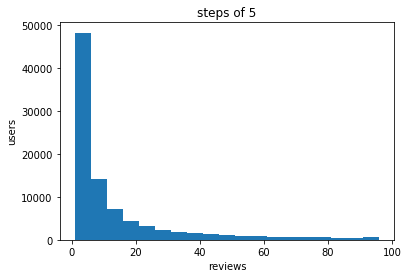

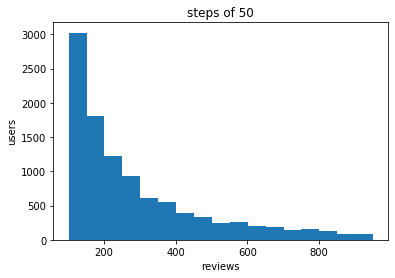

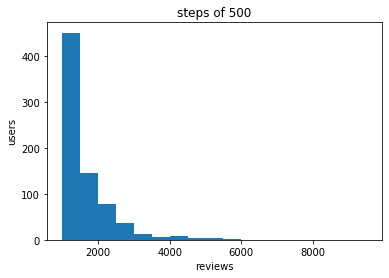

In [16]:
# visualize number of user reviews per user
plt.figure()
plt.title(label="steps of 5")
plt.xlabel('reviews')
plt.ylabel('users')
plt.hist(x = user_num_reviews_df['num_reviews'], bins = range(1,101,5))

plt.figure()
plt.title(label="steps of 50")
plt.xlabel('reviews')
plt.ylabel('users')
plt.hist(x = user_num_reviews_df['num_reviews'], bins = range(101,1001,50))

plt.figure()
plt.title(label="steps of 500")
plt.xlabel('reviews')
plt.ylabel('users')
plt.hist(x = user_num_reviews_df['num_reviews'], bins = range(1001,10001, 500))

**Note:** There is a high concentration of users who only left a few reviews. I think A good way to represent this data would be bag-of-words style where attributes are beers, although that will result in a HUGE number of attributes

In [17]:
beer_group = df_orig.groupby('beer_full', sort=True)

In [18]:
# get the number of reviews per beer, make it a dataframe
beer_num_reviews_df = beer_group.count().drop(columns=['user_score']).rename(columns={'user_id': 'num_reviews'})
# add a beer_id column numbered 0 through (numBeers-1). double 'reset' creates a numbered index then bumps it to
# a column, then we move beer_full back to the index
beer_num_reviews_df = beer_num_reviews_df.reset_index().reset_index().rename(columns={'index': 'beer_id'}).set_index('beer_full')

In [39]:
# sort beers by number of reviews
beer_num_reviews_df = beer_num_reviews_df.sort_values(by='num_reviews')

In [40]:
beer_num_reviews_df

,beer_id,num_reviews
beer_full,,
McMenamins Sweet Oblivion Porter,13607,3
McMenamins Devil's Bitter,13589,3
McMenamins Hill's Gold,13592,3
McMenamins Mango Unchained Double IPA (Brewmaster's Reserve),13598,3
Granite City Food & Brewery Bump in the Night,9269,4
...,...,...
The Alchemist Heady Topper,21086,14502
Russian River Brewing Company Pliny The Elder,18504,14633
Bell's Brewery - Eccentric Café & General Store Two Hearted Ale,2577,14826


In [41]:
# statistics around number of ratings per beer
print('average number of reviews per beer:\t', beer_num_reviews_df['num_reviews'].mean())
print('median of reiviews per beer:\t\t', beer_num_reviews_df['num_reviews'].median())
print('max number of reviews per beer:\t\t', beer_num_reviews_df['num_reviews'].max())

average number of reviews per beer:	 223.60565561078965
median of reiviews per beer:		 54.0
max number of reviews per beer:		 17070


(array([416., 201., 111., 105.,  52.,  39.,  34.,  16.,  17.,  17.,  14.,
         14.,   6.,  12.,   1.,   5.,   3.]),
 array([1001, 1501, 2001, 2501, 3001, 3501, 4001, 4501, 5001, 5501, 6001,
        6501, 7001, 7501, 8001, 8501, 9001, 9501]),
 <a list of 17 Patch objects>)

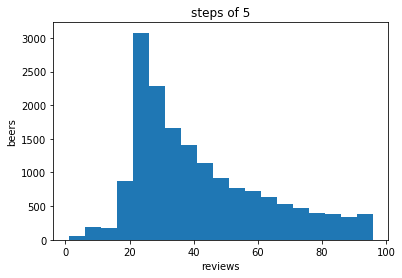

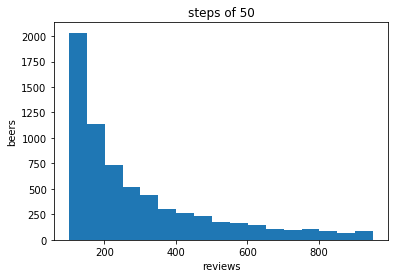

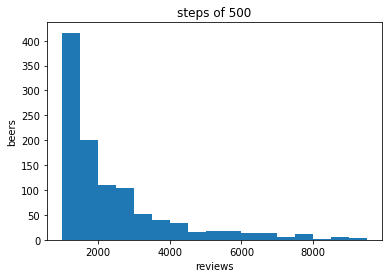

In [42]:
plt.figure()
plt.title(label="steps of 5")
plt.xlabel('reviews')
plt.ylabel('beers')
plt.hist(x = beer_num_reviews_df['num_reviews'], bins = range(1,101,5))

plt.figure()
plt.title(label="steps of 50")
plt.xlabel('reviews')
plt.ylabel('beers')
plt.hist(x = beer_num_reviews_df['num_reviews'], bins = range(101,1001,50))

plt.figure()
plt.title(label="steps of 500")
plt.xlabel('reviews')
plt.ylabel('beers')
plt.hist(x = beer_num_reviews_df['num_reviews'], bins = range(1001,10001, 500))

In [43]:
# more stats about ratings per beer
minNum = 25
perc_dropped = beer_num_reviews_df[beer_num_reviews_df['num_reviews'] < minNum]['beer_id'].count()/beer_num_reviews_df['beer_id'].count()

In [44]:
print('there are %d beers with less than %d reviews. this makes %.3f of the data\n'
       %(perc_dropped*beer_num_reviews_df['beer_id'].count(), minNum, perc_dropped))

there are 3859 beers with less than 25 reviews. this makes 0.157 of the data



**Note:** could drop the 15.7% of beers with less than 25 reviews to help reduce attributes in bag of words format.

In [45]:
# dictionaries used to convert beer id (int) to beer name (str) and visa versa
beer_name2id = dict(zip(beer_num_reviews_df.index, beer_num_reviews_df['beer_id']))
beer_id2name = dict(zip(beer_num_reviews_df['beer_id'], beer_num_reviews_df.index))

In [25]:
# add the beer ID's to the original dataframe, re-organize the columns and drop the beer names
df = df_orig
beer_id_array = [beer_name2id[name] for name in df_orig['beer_full']]
df['beer_id'] = beer_id_array
df = df.drop(columns=['beer_full'])[['beer_id', 'user_score', 'user_id']]

In [46]:
df

,beer_id,user_score,user_id
0,18580,3.75,1
1,18570,4.25,1
2,18581,4.25,1
3,4200,4.25,1
4,1,4.50,1
...,...,...,...
5487725,19337,3.50,102604
5487726,19332,3.50,102604
5487727,19347,3.82,102605
5487728,20332,4.17,102605


In [47]:
# write data to csv files
beer_num_reviews_df['beer_id'].to_csv('./Beer_Data/beer_ids.csv')

In [48]:
df.to_csv('./Beer_Data/numeric_beer_data.csv', index=False)

In [49]:
# get beer ID's of beers with 72 or more ratings
beers_2_keep = beer_num_reviews_df[beer_num_reviews_df["num_reviews"] >= 72]["beer_id"].tolist()
len(beers_2_keep) # there are 20683 beers that will be kept

9999

In [50]:
user_num_reviews_df

,user_id,num_reviews
0,1,27
1,2,370
2,3,5391
3,4,412
4,5,2440
...,...,...
102601,102602,1
102602,102603,1
102603,102604,2
102604,102605,2


In [51]:
users_2_keep = user_num_reviews_df[user_num_reviews_df['num_reviews'] >= 7]['user_id'].tolist()
len(users_2_keep)

50291

In [52]:
# drop beers with less than 72 reviews and save 'reduced' datasets
df_reduced = df[df['beer_id'].isin(beers_2_keep)]

In [54]:
# drop beers with less than 72 reviews from beer review count df, save to file
beer_num_reviews_df_reduced = beer_num_reviews_df[beer_num_reviews_df.beer_id.isin(beers_2_keep)]

In [57]:
beer_num_reviews_df_reduced.to_csv('./Beer_Data/reduced_reviews_per_beer.csv', index=False)

In [53]:
df_reduced.to_csv('./Beer_Data/reduced_numeric_data.csv', index=False)

In [32]:
df_orig_reduced = df_orig[df['beer_id'].isin(beers_2_keep)]
df_orig_reduced.to_csv('./Beer_Data/reduced_data.csv', index=False)